In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

SMB Size
HML Value 
RMW Profitability 
CMA Investment 
UMD Momentum 

In [2]:
path = 'momentum_data.xlsx'
df_mom_size = pd.read_excel(path, sheet_name=4).set_index('Date')
df_factors = pd.read_excel(path, sheet_name=1).set_index('Date')
df_mom_size = df_mom_size.join(df_factors)

rf = pd.read_excel(path, sheet_name=5).set_index('Date')
df_mom_size = df_mom_size.join(rf)

df_momentum = pd.read_excel(path, sheet_name=3).set_index('Date')
df_momentum = df_momentum.join(rf)

In [3]:
df_mom_size['rx_mom_FF'] = (1/2 *(df_mom_size['BIG HiPRIOR'] + df_mom_size['SMALL HiPRIOR']) -
  1/2 * (df_mom_size['BIG LoPRIOR'] + df_mom_size['SMALL LoPRIOR'])) # same as UMD 
df_mom_size['rx_mom_FF']

Date
1927-01-31    0.0036
1927-02-28   -0.0215
1927-03-31    0.0362
1927-04-30    0.0430
1927-05-31    0.0301
               ...  
2022-05-31    0.0248
2022-06-30    0.0080
2022-07-31   -0.0397
2022-08-31    0.0210
2022-09-30    0.0353
Name: rx_mom_FF, Length: 1149, dtype: float64

In [7]:
def table_row(df, portfolio, annualize_factor=12):
    mean = df[portfolio].mean() * annualize_factor
    vol = df[portfolio].std() * np.sqrt(annualize_factor)
    sharpe_ratio = mean/vol
    skew = df[portfolio].skew() #unscaled
    corr = df[[portfolio, 'MKT', 'HML']].corr()
    corr_to_mkt = corr.loc[portfolio, 'MKT']
    corr_to_value = corr.loc[portfolio, 'HML']
    return [mean, vol, sharpe_ratio, skew, corr_to_mkt, corr_to_value]


table1 = pd.DataFrame(index=['1927-2022', '1927-1993', '1994-2008', '2009-2022'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table1.loc['1927-2022', :] = table_row(df_mom_size.loc['1927':'2022',:], portfolio='rx_mom_FF')
table1.loc['1927-1993', :] = table_row(df_mom_size.loc['1927':'1993',:], portfolio='rx_mom_FF')
table1.loc['1994-2008', :] = table_row(df_mom_size.loc['1994':'2008',:], portfolio='rx_mom_FF')
table1.loc['2009-2022', :] = table_row(df_mom_size.loc['2009':'2022',:], portfolio='rx_mom_FF')
table1.style.set_caption('Solution Table 1: Momentum performance over time.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
1927-2022,0.077240,0.162646,0.474897,-3.015709,-0.344779,-0.417589
1927-1993,0.090075,0.159987,0.563018,-3.809269,-0.362513,-0.494935
1994-2008,0.104327,0.175548,0.594291,-0.582412,-0.234513,-0.130661
2009-2022,-0.014851,0.159281,-0.093237,-2.811279,-0.377895,-0.385130


(b) Momentum's performance has been fairly consistent over the entire sample except that in the past 12 years the mean return has been very poor. This is driven mostly by the year 2009. Note that even in the final subsample the correlations to the market and value are close to their usual values, and the overall volatility is close to the usual.

It's also noticeable that in the subperiod 1994-2008, the momentum has the best performance. The sharpe ratio is the highest, and the sknewness is only slightly negative. The correlations to the market and the value factor are the lowest. And this is exactly the period that momentum was published and well-practiced.

(c) The persistent performance over time (except for the 2009 crash which causes low mean return in 2009-2022) seems to support the idea that momentum is not just a statistical anomaly. Even in the final subsample, it gives negative correlation to the market and value to the point it is valuable to a mean-variance investor even with a mean return near zero.

In [8]:
df_mom_size['rx_mom_U_FF'] = (1/2 * (df_mom_size['BIG HiPRIOR'] + df_mom_size['SMALL HiPRIOR']) -
    df_mom_size['RF'])

table2 = pd.DataFrame(index=['long_short', 'long_only'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table2.loc['long_short', :] = table_row(df_mom_size['1994':], portfolio='rx_mom_FF')
table2.loc['long_only', :] = table_row(df_mom_size['1994':], portfolio='rx_mom_U_FF')
table2.style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
long_only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


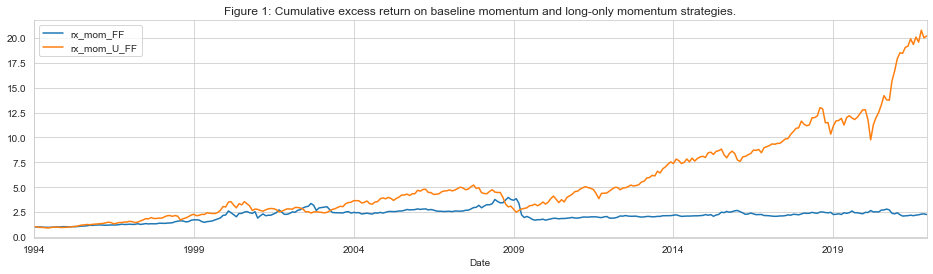

In [9]:
sns.set_style("whitegrid")
(df_mom_size.loc['1994':'2021', 'rx_mom_FF'] + 1).cumprod().plot(figsize=(16,4))
(df_mom_size.loc['1994':'2021', 'rx_mom_U_FF'] + 1).cumprod().plot(figsize=(16,4))
plt.title('Figure 1: Cumulative excess return on baseline momentum and long-only momentum strategies.')
plt.legend();

(b) During the period of 1994-2021, the mean, and Sharpe ratio are much higher in the long-only strategy, while the vol is about the same. It also has much less skewness. On these measures, it looks even more attractive.

(c) The long-only strategy is extremely correlated with the market and thus should not be promoted based on its diversification to the market. The long-short strategy has almost no market correlation and substantially negative correlation to value.

(d) See Figure 1. From 1994 to 2021, the long-and-short momentum stratery only out-performed the long-only strategy in 2003 and 2009. There one sees that the long-and-short momentum strategy suffered massive losses in 2009, (roughly -80% return,) while the long-only strategy was down about 50% in 2008 and up in 2009. This is a good illustration of the long-only strategy having less skewness. After 2009, the performance of long-and-short stratery was quite stable, and it has never returned to the previous level. On the other hand, the long-only strategy has recovered and soared after 2009.

In [10]:
df_momentum['rx_mom_D1'] = df_momentum['Hi PRIOR'] - df_momentum['Lo PRIOR']
table3 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

df = df_mom_size.join(df_momentum, rsuffix='momentum_')
df['rx_mom_D3'] = (1/3 * (df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/3 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3']))
df['rx_mom_D5'] = (1/5 * (df['PRIOR 6'] + df['PRIOR 7'] + df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/5 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3'] + df['PRIOR 4'] + df['PRIOR 5']))
table3.loc['rx_mom_D1', :] = table_row(df['1994':], portfolio='rx_mom_D1')
table3.loc['rx_mom_D3', :] = table_row(df['1994':], portfolio='rx_mom_D3')
table3.loc['rx_mom_D5', :] = table_row(df['1994':], portfolio='rx_mom_D5')

table3.style.set_caption('Table 3: Robustness of momentum construction.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
rx_mom_D1,0.079409,0.297952,0.266515,-1.323613,-0.335574,-0.236392
rx_mom_D3,0.034203,0.192568,0.177615,-1.355380,-0.365386,-0.229882
rx_mom_D5,0.018031,0.134026,0.134536,-1.435409,-0.357936,-0.227501


In [11]:
table2.style.set_caption('Solution Table 2: Long-only momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
long_only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


(b) The lecture implies that the more extreme the cutoff for the "winners", the higher the mean return of the momentum portfolio. The downside is that we would expect higher volatility. This is consistent with what we see here.

(c) If AQR can accept a higher volality and take on high concentrations in individual stocks, it can consider the 1-decile contruction as a retail product as the performance of the 1-decile construction is stronger. If AQR chooses the 5-decile construction, it means that it will hold all securities on the market, the trading costs from the rebalancing would be huge and the premium would be smaller too, but it has a smaller volality and a very diversified portfolio. I don't think AQR will choose either option.

(d) The Fama-French construction has a larger mean, a smaller vol, and thus a higher sharpe ratio. Other measures are on the same scale as those of the 3-decile construction. This shows that segment by size actually gives a better performance.

In [12]:
df['rx_mom_S'] = df['SMALL HiPRIOR'] - df['SMALL LoPRIOR']
df['rx_mom_B'] = df['BIG HiPRIOR'] - df['BIG LoPRIOR']
table4 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ','corr_to_v'])
table4.loc['rx_mom_FF', :] = table_row(df['1994':], portfolio='rx_mom_FF')
table4.loc['rx_mom_S', :] = table_row(df['1994':], portfolio='rx_mom_S')
table4.loc['rx_mom_B', :] = table_row(df['1994':], portfolio='rx_mom_B')
table4.style.set_caption('Table 4: Small stock momentum performance.')

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_v
rx_mom_FF,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
rx_mom_S,0.062737,0.171615,0.365571,-1.750109,-0.306908,-0.164672
rx_mom_B,0.031920,0.181863,0.175517,-0.857615,-0.277984,-0.286919


It doesn't seem like the attractiveness of the momentum strategy is mostly driven by the small stocks as the all three momentum constructions have comparable performance. However, when taking the regulatory and liquidity issue into consideration, a momentum strategy in large stocks still delivers excess returns at comparable risk.

5. 
The AQR retail product is substantially different from what we typically refer to as momentum. Though it has strong expected returns, it is almost all from market premium. This is a feature of being long-only and won't be fixed by modifying the exact constructions decile, sorting by size, etc.